In [1]:
#import important modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as skl
import json
import pickle
import re
import pprint
import datetime
import statistics as st
import seaborn as sns

In [2]:
import sqlite3
high_performance_mode = False #Changed this to default false
db_file_path = "db.db" #CHANGE THIS
from urllib.parse import unquote
from urllib.parse import quote

In [3]:
##DO NOT TOUCH THESE
db = sqlite3.connect(":memory:")
db2 = sqlite3.connect(db_file_path)
##DO NOT TOUCH THESE
if high_performance_mode:
    db2.backup(db)
    db2.close()
else:
    db = db2
db.execute('PRAGMA journal_mode = MEMORY')
#Rollback journal in mem so that indexing is faster and crashes are catastrophic >:D
db.execute('PRAGMA cache_size = 536870912') #<- 512MB in B
#This is dinamically resized but the default is really low so let it grow!
db.execute('PRAGMA temp_store = MEMORY')
#Anything that needs to be generated, do it in mem because faster
db.execute('PRAGMA locking_mode = EXCLUSIVE')
#Remove lock/unlock overhead let it zoom
print("Loaded")

Loaded


In [4]:
c = db.cursor()
class Helper:
      def __init__(self, db):
        self.db = db;
        #If anybody wants to use this Google "SQLite IN"
        self.airline_names = {20626359: 'virginatlantic', 18332190: 'British Airways', 22536055: 'American Airlines', 1542862735: 'Ryanair', 38676903: 'easyJet', 124476322: 'Lufthansa', 218730857: 'Qantas', 106062176: 'Air France', 56377143: 'Royal Dutch Airlines', 45621423: 'SocialLogin%40etihad.ae', 253340062: 'Singapore Airlines', 26223583: 'airberlin', 2182373406: 'airberlin Assist'}
        self.airline_ids = [56377143, 106062176, 18332190, 22536055, 124476322, 26223583, 2182373406, 38676903, 1542862735, 253340062, 218730857, 45621423, 20626359]
      def exec_custom(self, query: str):
        return self.db.execute(query)
      def get_vars(self, table: str):
        return self.db.execute("pragma table_info('{0}');".format(table))
      def get_tables(self): 
        return self.db.execute("SELECT name FROM sqlite_master WHERE type ='table' AND name NOT LIKE 'sqlite_%';")
      def get_tweet(self, id: int, vars, filter):
        return self.db.execute(self.build_query('tweets', vars, filter))
      def get_user_tweets(self, id: int):
        return self.db.execute(self.build_query('tweets', '*', [['user', id]]))
      def get_airline_tweets_by_mention(self, id: int, vars):
        return self.db.execute(self.build_query('mentions', vars, "WHERE user_id = '{0}'".format(id)))
      def get_airline_tweets_by_user_id_in_tweet(self, id: int, vars):
        return self.db.execute(self.build_query('tweets', vars, "WHERE user = '{0}'".format(id)))
      def build_query(self, table, return_values, search_values, raw_filter = 0):
        def createLimit(limit: list):
            return limit[0] + " = " + "'{0}'".format(limit[1])
        #You'd have to sort and/or/* search values and then apply them accordingly because of how the .join function works and im not about that life
        #Or use the list comprehension output to process the logic behind it (but usually complex things require brackets and f that)
        if(type(search_values) == list):
            query = "select " + ",".join(return_values) + " from " + table + " where " + ' and '.join([createLimit(limit) for limit in search_values])
        else:
            query = "select " + ",".join(return_values) + " from " + table + " where " + search_values
        return query


In [5]:
hp = Helper(c)

In [6]:
#See all tables
hp_t = Helper(db)
for table_name in hp_t.get_tables():
    print('<[{0}]>'.format(table_name[0]))
    for column_name in hp_t.get_vars(table_name[0]):
        print("    {0}".format(column_name[1]))

<[tweets]>
    id
    text
    in_reply_to_status_id
    in_reply_to_user_id
    user
    retweeted_status
    quoted_status
    language
    timestamp_ms
<[users]>
    timestamp
    id
    name
    verified
    followers_count
    friends_count
    listed_count
    favourites_count
    statuses_count
    location
<[retweets]>
    id
    in_reply_to_status_id
    in_reply_to_user_id
    user
<[quotes]>
    id
    in_reply_to_status_id
    in_reply_to_user_id
    user
<[to_delete]>
    id
    timestamp
<[ent_hashtags]>
    id
    text
<[ent_urls]>
    id
    url
<[ent_mentions]>
    id
    name
    user_id
<[convs]>
    root
    reply
    id
    level


In [7]:
airlines = {'KLM':56377143, 
            'AirFrance': 106062176, 
            'British_Airways': 18332190, 
            'AmericanAir': 22536055, 
           'Lufthansa': 124476322, 
           'AirBerlin': 26223583, 
           'AirBerlinAssist': 2182373406, 
           'easyJet': 38676903, 
           'RyanAir': 1542862735, 
           'SingaporeAir': 253340062, 
           'Qantas': 218730857, 
           'EtihadAirways': 45621423, 
           'VirginAtlantic': 20626359}

In [8]:
air_count = pickle.load(open("save2.p", "rb"))

In [9]:
#noticed there are two keys we don't need
del air_count['AirBerlin']['nr_convs']
del air_count['AirBerlinAssist']['nr_convs']

# A-B-A structure for the sentiment analysis

First, find the tweets from users that get a reply later on (only KLM)

In [10]:
unfiltered_a_q = """
SELECT DISTINCT(id) as 'start', user as 'user_id'
FROM tweets
WHERE tweets.user != 56377143 AND tweets.id IN ({0}) AND tweets.in_reply_to_user_id = 'null' 
AND id IN (SELECT DISTINCT(in_reply_to_status_id) FROM tweets WHERE user = 56377143 AND in_reply_to_status_id != 'null')
""".format(','.join([str(x) for x in air_count['KLM']['ids']]))

unfiltered_a = pd.read_sql_query(unfiltered_a_q, db)
unfiltered_a #these are the tweets directly sent from users that get a reply

,start,user_id
0,1131185677230575600,824207173425262600
1,1131215415164702700,123663454
2,1131260934087991300,267418667
3,1131277493674156000,2186639444
4,1131281689051828200,977096243204804600
...,...,...
3449,1243899605483323400,66617261
3450,1243920892272562200,187541638
3451,1244183751820742700,934431504
3452,1244521027285045200,52662462


We have to filter these tweets to those that end in a ABA structured converstion 

   - going backwards from the third (A) tweet to klm's reply (B) 

In [11]:
b_tweets_id = """(SELECT DISTINCT(id) FROM tweets WHERE tweets.user = 56377143 AND in_reply_to_status_id IN ({0}))""".format( ','.join([str(x) for x in unfiltered_a['start']]))
b_tweets_in_reply_user = """(SELECT DISTINCT(in_reply_to_user_id) FROM tweets WHERE tweets.user = 56377143 AND in_reply_to_status_id IN ({0}))""".format( ','.join([str(x) for x in unfiltered_a['start']]))
a_tweets = """(SELECT DISTINCT(in_reply_to_status_id) FROM tweets WHERE tweets.user = 56377143 AND in_reply_to_status_id IN ({0}))""".format( ','.join([str(x) for x in unfiltered_a['start']]))
backward_a_b_q = """
SELECT DISTINCT(id) as 'change', user as 'user_id', in_reply_to_status_id as 'klms reply'
FROM tweets
WHERE tweets.user != 56377143 AND tweets.id IN ({0}) AND tweets.user IN {1}
AND tweets.in_reply_to_status_id IN {2}
""".format(','.join([str(x) for x in air_count['KLM']['ids']]), b_tweets_in_reply_user, b_tweets_id)
backward_a_b = pd.read_sql_query(backward_a_b_q, db)
backward_a_b #klms reply to original user tweet and a users reply to that reply

,change,user_id,klms reply
0,1131190988561629200,824207173425262600,1131188287803142100
1,1131191297312723000,824207173425262600,1131188287803142100
2,1131283711679508500,2186639444,1131282681692610600
3,1131283955230105600,977096243204804600,1131283320266993700
4,1131503882079809500,146872603,1131502675101659100
...,...,...,...
770,1243722308457361400,73875631,1243715503677415400
771,1244351715790459000,1935225229,1243766315908837400
772,1244550930365927400,146872603,1244550301018992600
773,1244559335902118000,146872603,1244550301018992600


- first (A) tweets from users that ended in a conversation

In [12]:
a_tweets_q = """
SELECT in_reply_to_status_id as 'start'
FROM tweets
WHERE id IN ({0})
""".format(','.join([str(x) for x in backward_a_b['klms reply']]))
a_tweets = pd.read_sql_query(a_tweets_q, db)
a_tweets #filtered original first tweets that get a reply and reply to a reply 

,start
0,1131185677230575600
1,1131277493674156000
2,1131277493674156000
3,1131281689051828200
4,1131281689051828200
...,...
719,1243172327854047200
720,1243702683564834800
721,1241403462379884500
722,1244545235130220500


# Plots for user followers 

- KLM received about 133 000 tweets from users (whether directly or as a reply)
- did they respond more to popular users?

In [24]:
followers = pd.DataFrame()
followers['user'] = unfiltered_a['user_id'] #users that sent a request and got an answer

followers_q = """
SELECT followers_count
FROM users
WHERE id IN ({0})
""".format(','.join([str(x) for x in followers['user']]))
#get the number of followers from these users 
followers_2 = pd.read_sql_query(followers_2_q, db)
followers['followers_count'] = followers_2['followers_count']
followers

,user,followers_count
0,824207173425262600,3694
1,123663454,3753
2,267418667,3766
3,2186639444,360
4,977096243204804600,364
...,...,...
3449,66617261,34422
3450,187541638,33532
3451,934431504,33428
3452,52662462,33428


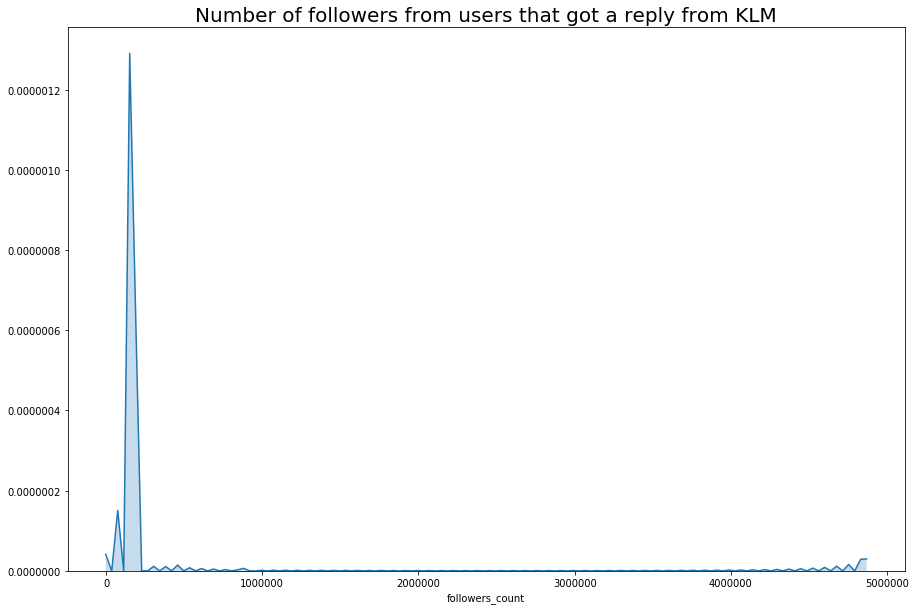

In [25]:
plt.figure(figsize=(15,10))
sns.distplot(followers['followers_count'], hist=False, kde_kws = {'shade': True})
plt.title('Number of followers from users that got a reply from KLM', size=20);

This only shows us the absolute numbers of the followers count. Now we will bin the numbers and check for percentages of KLM's replies to those 'popularity bins' of customers 

In [34]:
bins = [np.percentile(followers['followers_count'], (n+1)*10) for n in range(10)] 
for i in range(len(bins)):
    bins[i] = round(bins[i])
bins #these are the percentiles of followers_count

[177.0,
 459.0,
 886.0,
 1330.0,
 1729.0,
 2346.0,
 3353.0,
 7649.0,
 19056.0,
 4867376.0]

In [35]:
cum_freq = []
for i in bins:
    bins_q = """
    SELECT COUNT(DISTINCT(id))
    FROM users
    WHERE id IN ({0}) AND followers_count <= {1}
    """.format(','.join([str(x) for x in followers['user']]), i)
    for row in hp.exec_custom(bins_q):
        cum_freq.append(row[0])
cum_freq #how many users there are with less or equal to every followers_count percentile

[1217, 1836, 2215, 2423, 2538, 2649, 2763, 2893, 2969, 3051]

We now get how many users that got a reply there are in each bin

In [36]:
bin_freq = [cum_freq[0]]
for i in range(len(cum_freq)-1):
    bin_freq.append(cum_freq[i+1]-cum_freq[i])
bin_freq

[1217, 619, 379, 208, 115, 111, 114, 130, 76, 82]

In [37]:
sent_from_users_q = """
SELECT DISTINCT(tweets.id) as 'start', tweets.user as 'user_id'
FROM tweets
WHERE user != 56377143 AND id IN ({0}) AND in_reply_to_user_id = 'null' 
""".format(','.join([str(x) for x in air_count['KLM']['ids']]))

all_sent_direct = pd.read_sql_query(sent_from_users_q, db)
all_sent_direct #all requests from users to klm whether replied or not 

,start,user_id
0,1131173345435762700,67642736
1,1131173692086599700,728236673037914100
2,1131175578869092400,1065921377654444000
3,1131179496994934800,56459096
4,1131179799764983800,976913773381537800
...,...,...
55817,1244693028524130300,80128823
55818,1244693094412533800,80128823
55819,1244693824519184400,1870191091
55820,1244694239793070000,314566049


In [38]:
followers_all = pd.DataFrame()
followers_all['user'] = all_sent_direct['user_id']

followers_all_q = """
SELECT followers_count
FROM users
WHERE id IN ({0})
""".format(','.join([str(x) for x in followers_all['user']]))
#get the number of followers from these users 
followers_all_2 = pd.read_sql_query(followers_all_q, db)
followers_all['followers_count'] = followers_all_2['followers_count']
followers_all

,user,followers_count
0,67642736,109
1,728236673037914100,44323
2,1065921377654444000,20
3,56459096,732
4,976913773381537800,1629
...,...,...
55817,80128823,441
55818,80128823,770
55819,1870191091,393
55820,314566049,385


In [41]:
cum_freq_all = []
for i in bins:
    bins_q = """
    SELECT COUNT(DISTINCT(id))
    FROM users
    WHERE id IN ({0}) AND followers_count <= {1}
    """.format(','.join([str(x) for x in all_sent_direct['user_id']]), i)
    for row in hp.exec_custom(bins_q):
        cum_freq_all.append(row[0])
cum_freq_all #how many users there are with less or equal to every followers_count percentile   

[9719, 14507, 17888, 19828, 21009, 22247, 23463, 25342, 26560, 27953]

In [42]:
bin_freq_all = [cum_freq_all[0]]
for i in range(len(cum_freq_all)-1):
    bin_freq_all.append(cum_freq_all[i+1]-cum_freq_all[i])
bin_freq_all 

[9719, 4788, 3381, 1940, 1181, 1238, 1216, 1879, 1218, 1393]

In [55]:
ratio_per_bin = pd.DataFrame({'percentile_followers' : ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100']})
#added bins for the x axis
ratios = [] 
for i in range(len(bin_freq)):
    ratios.append(bin_freq[i]/bin_freq_all[i])
ratio_per_bin['ratio'] = ratios #ratio of tweets that get a reply to all sent for each bin

In [56]:
ratio_per_bin

,percentile_followers,ratio
0,0-10,0.125219
1,10-20,0.129282
2,20-30,0.112097
3,30-40,0.107216
4,40-50,0.097375
5,50-60,0.089661
6,60-70,0.093750
7,70-80,0.069186
8,80-90,0.062397
9,90-100,0.058866


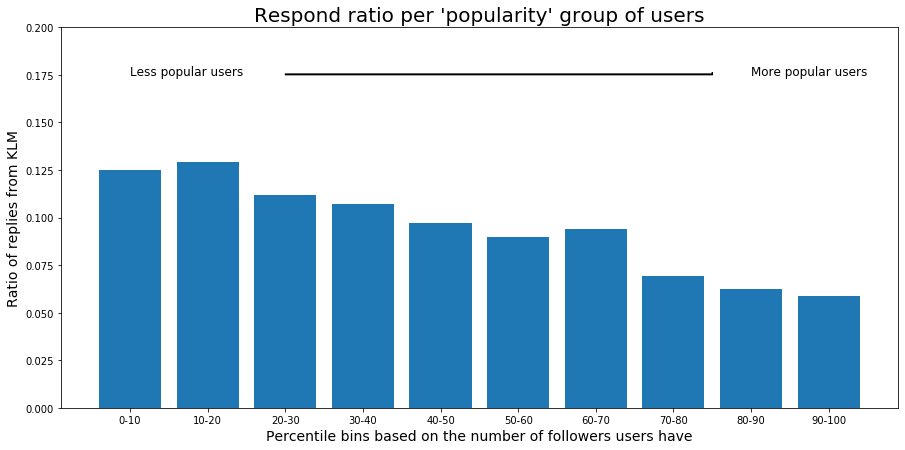

In [79]:
plt.figure(figsize=(15, 7))
plt.bar(ratio_per_bin['percentile_followers'], ratio_per_bin['ratio'])
plt.title("Respond ratio per 'popularity' group of users", size=20)
plt.xlabel('Percentile bins based on the number of followers users have', size=14)
plt.ylabel('Ratio of replies from KLM', size=14)
plt.ylim(0, 0.2)
plt.text(x='0-10', y=0.175, s='Less popular users', fontsize=12)
plt.text(x='80-90', y=0.175, s='More popular users', fontsize=12)
plt.arrow(x=2, y=0.175, dx=5.5, dy=0, shape='right');